In [1]:
# preprocessing
import math
import random
import pandas as pd
import numpy as np
from datetime import date 
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
import preprocessing_local
# visualization
import matplotlib.pyplot as plt 
from pylab import *
# neural network
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.layers import LSTM 
from keras.models import model_from_json

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
startdate=date(2000,1,1)
enddate=date(2020,3,31)
retrain = True
training_epocs = 5
startdatestr=startdate.strftime('%d_%m_%Y')
enddatestr=enddate.strftime('%d_%m_%Y')
filename_date="./data/"+startdatestr+"_to_"+enddatestr+"_"
filename_date

'./data/01_01_2000_to_31_03_2020_'

In [5]:
# model_from_json
# !pip3 install nsepy --ignore-installed
import nsepy as nse
from nsetools import Nse
nsel = Nse()
stock_list = nsel.get_stock_codes()
stock_list= {v: k for k, v in stock_list.items()}

In [10]:
import nsepy as nse
iterator = iter(stock_list.items())
# for i in range(50):
#     print(next(iterator))
topG = pd.DataFrame(nsel.get_top_gainers())

topG.lastCorpAnnouncementDate=pd.to_datetime(topG.lastCorpAnnouncementDate,format='%d-%b-%Y')
print("top gainer")
topG.loc[topG.lastCorpAnnouncementDate>'2020-03-02']

top gainer


,symbol,series,openPrice,highPrice,lowPrice,ltp,previousPrice,netPrice,tradedQuantity,turnoverInLakhs,lastCorpAnnouncementDate,lastCorpAnnouncement
6,VEDL,EQ,118.5,122.2,116.3,117.20,119.35,1.52,10328909.0,12242.86,2020-03-05,Interim Dividend - Rs 3.9 Per Share
9,ASIANPAINT,EQ,1854.0,1878.0,1852.1,1870.05,1847.95,1.20,684042.0,12774.42,2020-03-03,Interim Dividend - Rs 7.15 Per Share


In [11]:
hightEnd=pd.DataFrame({'symbol':topG.symbol,'openPrice':topG.openPrice,'highPrice':topG.highPrice,'diff-open-high':topG.highPrice-topG.openPrice,'high %':np.round(((topG.highPrice-topG.openPrice)*100)/topG.openPrice,2)})
hightEnd.sort_values(by='high %',ascending=False)

,symbol,openPrice,highPrice,diff-open-high,high %
0,HINDUNILVR,2185.00,2253.75,68.75,3.15
6,VEDL,118.50,122.20,3.70,3.12
3,BRITANNIA,3082.60,3165.00,82.40,2.67
1,HCLTECH,568.00,581.90,13.90,2.45
5,WIPRO,229.05,233.40,4.35,1.90
7,TCS,2085.70,2118.95,33.25,1.59
8,ITC,187.55,190.35,2.80,1.49
2,UPL,518.90,525.90,7.00,1.35
9,ASIANPAINT,1854.00,1878.00,24.00,1.29
4,EICHERMOT,17450.00,17639.30,189.30,1.08


In [12]:
print("most traded")
topG.sort_values(by='tradedQuantity',ascending=False)

most traded


,symbol,series,openPrice,highPrice,lowPrice,ltp,previousPrice,netPrice,tradedQuantity,turnoverInLakhs,lastCorpAnnouncementDate,lastCorpAnnouncement
6,VEDL,EQ,118.50,122.20,116.30,117.20,119.35,1.52,10328909.0,12242.86,2020-03-05,Interim Dividend - Rs 3.9 Per Share
8,ITC,EQ,187.55,190.35,186.55,190.20,187.50,1.44,6110892.0,11517.81,2019-05-22,Dividend - Rs 5.75 Per Share
1,HCLTECH,EQ,568.00,581.90,563.15,578.90,563.10,2.81,1868249.0,10776.99,2020-01-24,Interim Dividend - Rs 2 Per Share
7,TCS,EQ,2085.70,2118.95,2084.05,2114.95,2083.20,1.52,1039420.0,21860.98,2020-01-23,Interim Dividend - Rs 5 Per Share
2,UPL,EQ,518.90,525.90,516.70,523.10,511.60,2.25,915397.0,4781.76,2019-07-02,Bonus 1:2
5,WIPRO,EQ,229.05,233.40,229.05,232.40,228.85,1.55,867048.0,2007.13,2020-01-24,Interim Dividend - Re 1 Per Share
0,HINDUNILVR,EQ,2185.00,2253.75,2181.85,2238.85,2175.85,2.90,841001.0,18775.18,2019-10-23,Interim Dividend - Rs 11 Per Sh
9,ASIANPAINT,EQ,1854.00,1878.00,1852.10,1870.05,1847.95,1.20,684042.0,12774.42,2020-03-03,Interim Dividend - Rs 7.15 Per Share
3,BRITANNIA,EQ,3082.60,3165.00,3076.10,3130.00,3063.05,2.19,272122.0,8527.81,2019-08-22,Scheme Of Arangement- Bonus - 1 Debenture For ...
4,EICHERMOT,EQ,17450.00,17639.30,17161.80,17547.95,17254.20,1.70,68664.0,11940.62,2019-07-24,Annual General Meeting/ Dividend - Rs 125 Per ...


In [13]:
number_of_company = int(input('Entert the number of company:\t'))
company_list =[]
for _ in range(number_of_company):
    name = input('Enter the Company to Predict\t:\t')
    company_list.append(name)

Entert the number of company:	3
Enter the Company to Predict	:	HINDUNILVR
Enter the Company to Predict	:	VEDL
Enter the Company to Predict	:	BRITANNIA


In [14]:
numbered = list(company_list)
# import sys
# sys.path

In [15]:
stock_data = list(company_list)
for i in range(number_of_company):
    fnm = filename_date+company_list[i]+".csv"
    try:
        stock_data[i] = pd.read_csv(fnm)
        print("file exist, loaded data")
    except FileNotFoundError as e:
        print(e)
        print("fetching from the internet")
        stock_data[i] = nse.get_history(symbol=company_list[i], start=startdate, end=enddate)
    stock_data[i].to_csv(filename_date+company_list[i]+".csv")
    print(fnm)
#     print(stock_data[i])

W0305 10:31:05.666356 123145556520960 connectionpool.py:298] Connection pool is full, discarding connection: cproxysrt.youbroadband.in


[Errno 2] File ./data/01_01_2000_to_31_03_2020_HINDUNILVR.csv does not exist: './data/01_01_2000_to_31_03_2020_HINDUNILVR.csv'
fetching from the internet


W0305 10:31:06.011008 123145840300032 connectionpool.py:298] Connection pool is full, discarding connection: cproxysrt.youbroadband.in
W0305 10:31:06.816453 123145556520960 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:06.849185 123145440907264 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:06.858105 123145577541632 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:06.862415 123145672134656 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:06.864455 123145419886592 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:06.869573 123145992699904 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:06.871716 123145619582976 connectionpool.py:298] Connection pool is full, discarding connec

./data/01_01_2000_to_31_03_2020_HINDUNILVR.csv
[Errno 2] File ./data/01_01_2000_to_31_03_2020_VEDL.csv does not exist: './data/01_01_2000_to_31_03_2020_VEDL.csv'
fetching from the internet


W0305 10:31:20.696254 123145514479616 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:20.733154 123145535500288 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:20.754706 123145493458944 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:20.757906 123145461927936 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:20.853294 123145619582976 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:20.861325 123145630093312 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:20.885274 123145556520960 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:20.912346 123145588051968 connectionpool.py:298] Connection pool is full, discarding connection: ww

./data/01_01_2000_to_31_03_2020_VEDL.csv
[Errno 2] File ./data/01_01_2000_to_31_03_2020_BRITANNIA.csv does not exist: './data/01_01_2000_to_31_03_2020_BRITANNIA.csv'
fetching from the internet


W0305 10:31:34.523756 123145735196672 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:34.525381 123145409376256 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:34.526461 123145745707008 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:34.527678 123145461927936 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:34.529171 123145777238016 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:34.530678 123145640603648 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:34.531768 123145619582976 connectionpool.py:298] Connection pool is full, discarding connection: www1.nseindia.com
W0305 10:31:34.532838 123145682644992 connectionpool.py:298] Connection pool is full, discarding connection: ww

./data/01_01_2000_to_31_03_2020_BRITANNIA.csv


In [ ]:
# for each_stock,number in zip(stock_data,numbered):
#     each_stock.to_csv(number+"_download_.csv")

In [16]:
for each_stock in stock_data:
    each_stock.drop(['Trades','Volume','%Deliverble','VWAP','Turnover','Last','Prev Close','Series','Symbol'], axis =1,inplace =True)

Adding feature, Change which gives the Volatility of stock, more the volatility better for day trading.

In [17]:
for each_stock in stock_data:
    each_stock['Change'] = each_stock['Close']-each_stock['Open']

In [18]:
for each_stock in stock_data:
    each_stock.loc[each_stock.Change >0, 'Gains'] = 1 
    each_stock.loc[each_stock.Change <0, 'Gains'] = -1 
    each_stock.loc[each_stock.Change ==0, 'Gains'] = 0 

Printing the first 5 values and description of data for each stock's dataframe.

In [19]:
for each_stock,number in zip(stock_data,numbered):
    print(number)
    print(each_stock.describe())

HINDUNILVR
              Open         High          Low        Close  Deliverable Volume  \
count  5023.000000  5023.000000  5023.000000  5023.000000        4.508000e+03   
mean    595.102777   602.755535   586.948238   594.807854        1.284127e+06   
std     588.391134   597.155805   578.926290   587.748360        1.092371e+06   
min     103.100000   108.000000   100.500000   106.150000        8.020000e+03   
25%     207.900000   211.000000   203.075000   207.425000        6.138175e+05   
50%     277.000000   280.850000   272.850000   276.750000        9.694205e+05   
75%     831.600000   841.625000   823.750000   832.075000        1.597723e+06   
max    3165.700000  3234.000000  3050.000000  3141.250000        1.482503e+07   

            Change        Gains  
count  5023.000000  5023.000000  
mean     -0.294923    -0.063508  
std      18.016740     0.995084  
min    -289.800000    -1.000000  
25%      -3.950000    -1.000000  
50%      -0.300000    -1.000000  
75%       3.400000   

In [20]:
print(numbered[0])
stock_data[0].describe()

HINDUNILVR


,Open,High,Low,Close,Deliverable Volume,Change,Gains
count,5023.000000,5023.000000,5023.000000,5023.000000,4.508000e+03,5023.000000,5023.000000
mean,595.102777,602.755535,586.948238,594.807854,1.284127e+06,-0.294923,-0.063508
std,588.391134,597.155805,578.926290,587.748360,1.092371e+06,18.016740,0.995084
min,103.100000,108.000000,100.500000,106.150000,8.020000e+03,-289.800000,-1.000000
25%,207.900000,211.000000,203.075000,207.425000,6.138175e+05,-3.950000,-1.000000
50%,277.000000,280.850000,272.850000,276.750000,9.694205e+05,-0.300000,-1.000000
75%,831.600000,841.625000,823.750000,832.075000,1.597723e+06,3.400000,1.000000
max,3165.700000,3234.000000,3050.000000,3141.250000,1.482503e+07,253.000000,1.000000


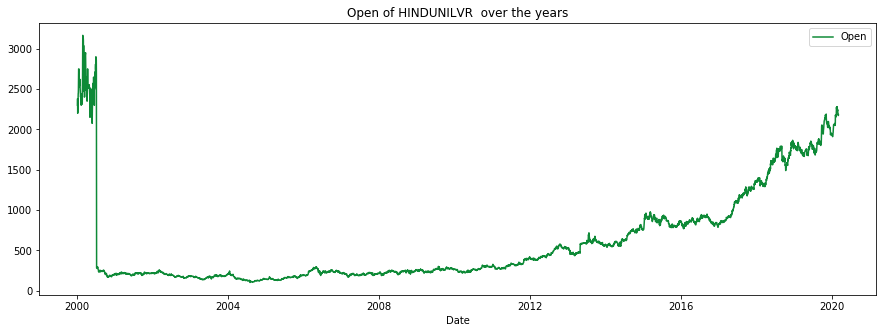

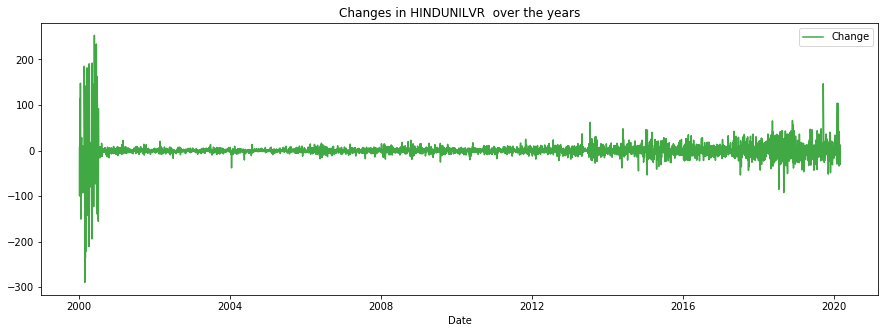

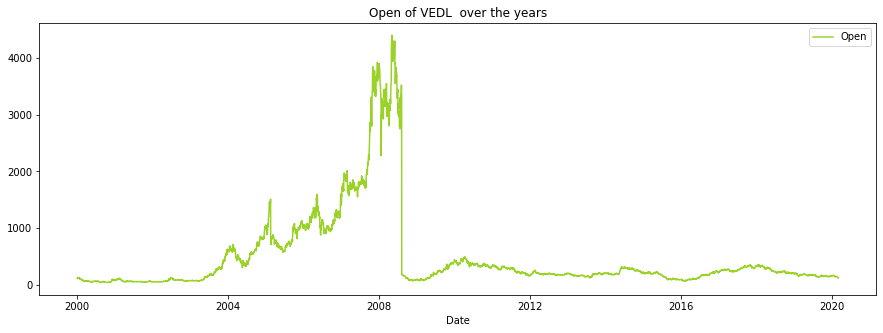

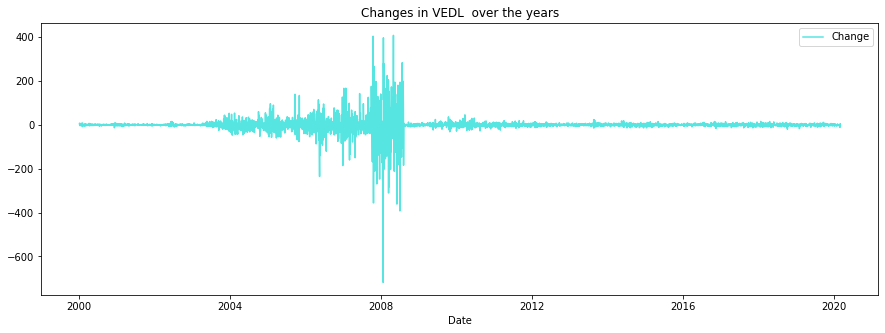

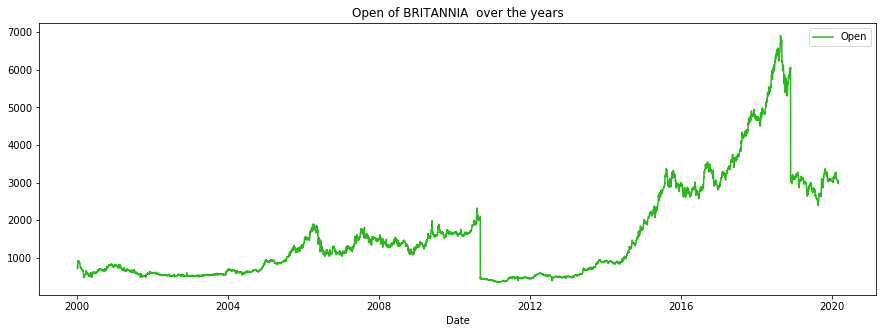

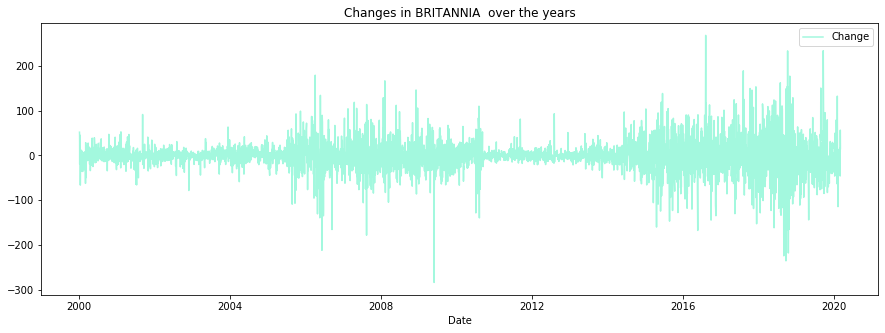

In [21]:
import random;
random.uniform(0, 1)
for each_stock,number in zip(stock_data,numbered):
    each_stock.plot(y ='Open',color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)),figsize=(15,5),title='Open of ' +number+ '  over the years')
    each_stock.plot(y='Change',color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)),figsize=(15,5),title ='Changes in '+ number+'  over the years')

Following are the major mesures for prediction.<br>
1. OHLC <br>
    An open-high-low-close chart is a type of chart typically used to illustrate movements in the price of a financial instrument over time.<br>
2. HLC - High Low Close graph<br>
3. Close - Closing price of each day

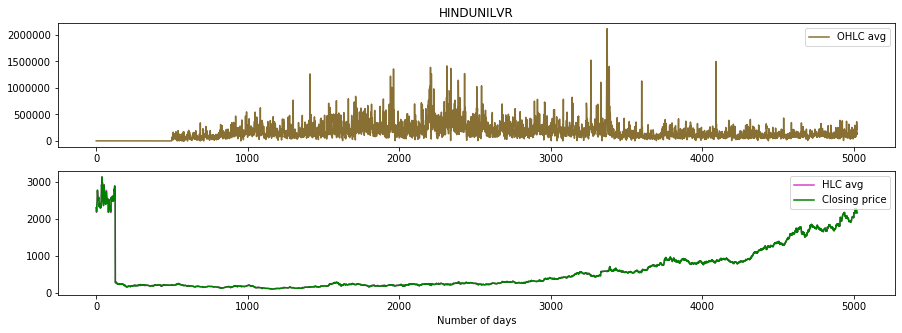

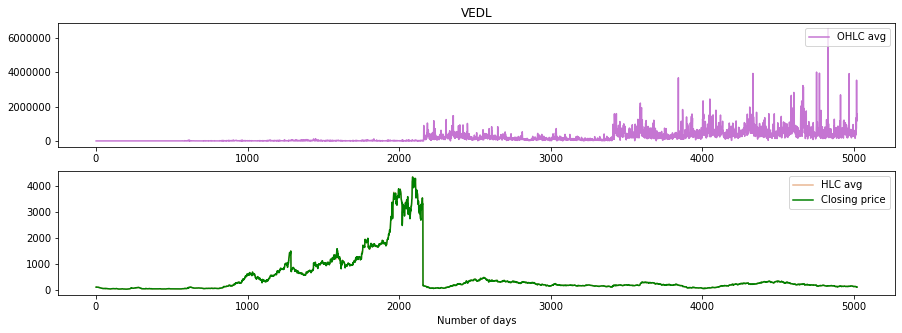

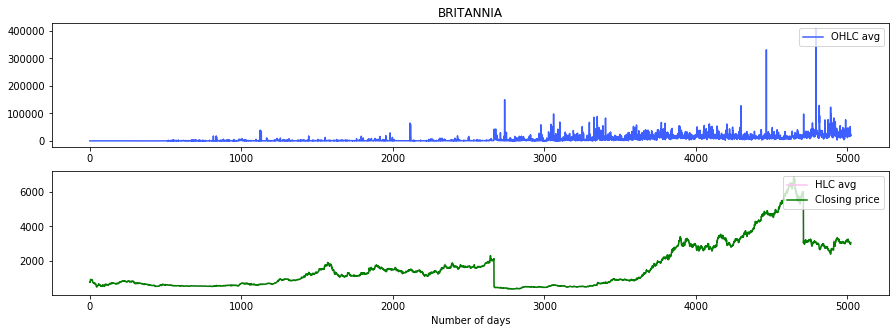

In [22]:
for each_stock,number in zip(stock_data,numbered):
    np.random.seed(7)
    obs = np.arange(1, len(each_stock) + 1, 1)
    OHLC_avg = each_stock.mean(axis = 1)
    HLC_avg = each_stock[['High', 'Low', 'Close']].mean(axis = 1)
    close_val= each_stock[['Close']]
    fig=plt.figure(figsize=(15,5))
    subplot(2,1,1)
    plt.plot(obs, OHLC_avg,color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)), label = 'OHLC avg')
    plt.legend(loc = 'upper right')
    plt.title(number)
    subplot(2,1,2)
    plt.plot(obs, HLC_avg, color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)), label = 'HLC avg')
    plt.plot(obs, close_val, 'g', label = 'Closing price')
    plt.legend(loc = 'upper right')
    plt.xlabel('Number of days')
    print('\n\n\n')
    plt.show()
    fig.savefig("images/"+number+"-1.png")

### Modeling 

Hindunilvr
force traning...
traning since, trained model couldn't be found


W0305 10:32:42.251627 4599774656 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/5
 - 12s - loss: 0.0035
Epoch 2/5
 - 17s - loss: 3.5185e-04
Epoch 3/5
 - 17s - loss: 3.3228e-04
Epoch 4/5
 - 13s - loss: 3.1557e-04
Epoch 5/5
 - 12s - loss: 3.0100e-04




Train RMSE of HINDUNILVR 51.99
Test RMSE of HINDUNILVR 97.46
saving model
Saved model to disk


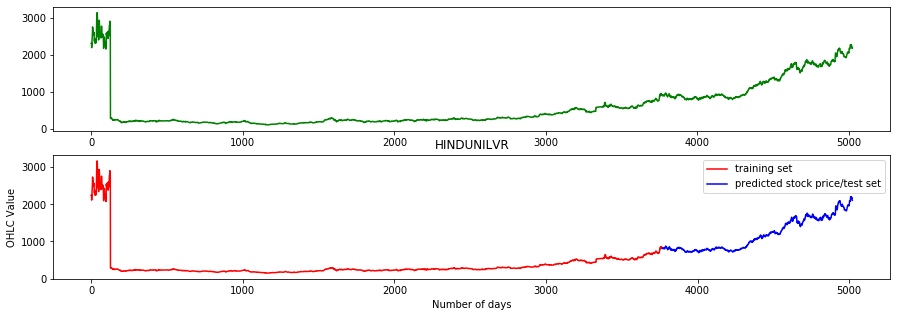

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:108: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:109: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Last Day Value of HINDUNILVR 2108.07177734375
Next Day Value ofHINDUNILVR 2134.4033203125
last_val before scaling  [2108.0718] [1.] [1.] [[[1.]]]


HINDUNILVR Positive cluster




Vedl
force traning...
traning since, trained model couldn't be found
Epoch 1/5
 - 13s - loss: 0.0033
Epoch 2/5
 - 12s - loss: 3.6674e-04
Epoch 3/5
 - 13s - loss: 3.0292e-04
Epoch 4/5
 - 13s - loss: 2.7078e-04
Epoch 5/5
 - 13s - loss: 2.4538e-04




Train RMSE of VEDL 65.96
Test RMSE of VEDL 13.24
saving model
Saved model to disk


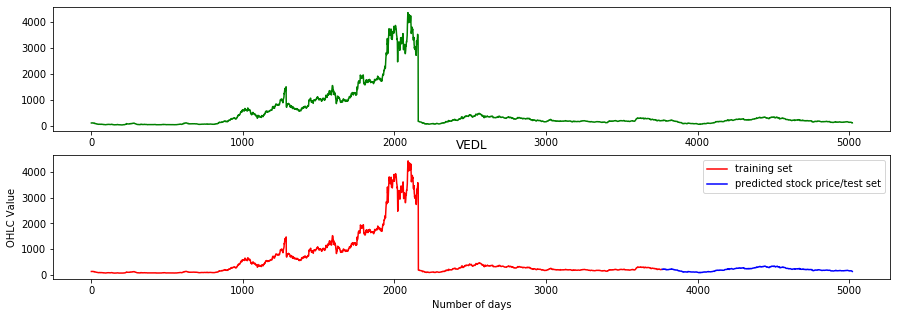

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:108: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:109: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Last Day Value of VEDL 132.8575439453125
Next Day Value ofVEDL 134.939697265625
last_val before scaling  [132.85754] [1.] [1.] [[[1.]]]


VEDL Positive cluster




Britannia
force traning...
traning since, trained model couldn't be found
Epoch 1/5
 - 14s - loss: 3.4592e-04
Epoch 2/5
 - 13s - loss: 3.2390e-05
Epoch 3/5
 - 14s - loss: 3.1373e-05
Epoch 4/5
 - 14s - loss: 3.0590e-05
Epoch 5/5
 - 13s - loss: 2.9893e-05




Train RMSE of BRITANNIA 35.05
Test RMSE of BRITANNIA 433.16
saving model
Saved model to disk


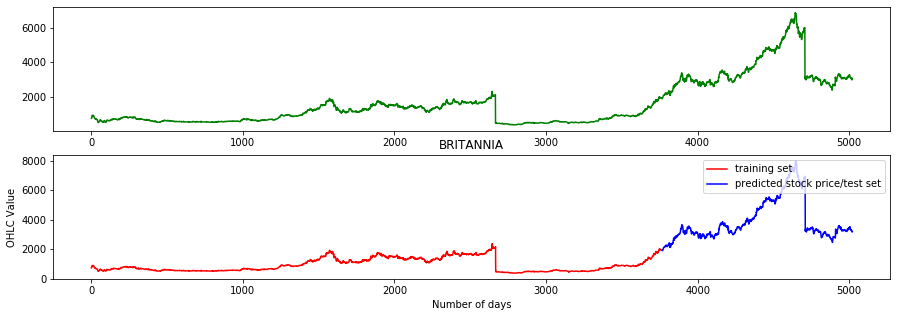

Last Day Value of BRITANNIA 3171.3525390625
Next Day Value ofBRITANNIA 3697.54345703125
last_val before scaling  [3171.3525] [1.] [1.] [[[1.]]]


BRITANNIA Positive cluster






/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:108: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:109: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [23]:
for each_stock,number in zip(stock_data,numbered):
# Selecting the necessary attributes for prediction 
    OHLC_avg = each_stock[['Open','High', 'Low', 'Close']].mean(axis = 1)
    HLC_avg = each_stock[['High', 'Low', 'Close']].mean(axis = 1)
    close_val= each_stock[['Close']]
    
# Converting to time series    
    OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    OHLC_avg = scaler.fit_transform(OHLC_avg)
    
# Splitting
    train_OHLC = int(len(OHLC_avg) * 0.75)
    test_OHLC = len(OHLC_avg) - train_OHLC
    train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# TIME-SERIES DATASET FOR TIME T, VALUES FOR TIME T+1
    trainX, trainY = preprocessing_local.new_dataset(train_OHLC, 1)
    testX, testY = preprocessing_local.new_dataset(test_OHLC, 1)

# Reshaping
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    step_size = 1

# LSTM MODEL
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
    model.add(LSTM(16))
    model.add(Dense(1))
    model.add(Activation('linear'))
    print(number.capitalize())
# Training
    try:
        if retrain & True:
            raise FileNotFoundError("force traning...")
        json_file = open(number+'model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(number+"model.h5")
        print("Loaded model from disk")
        model=loaded_model
    except FileNotFoundError as e:
        print(e)
        print("traning since, trained model couldn't be found")
        model.compile(loss='mean_squared_error', optimizer='adagrad') 
        model.fit(trainX, trainY, epochs=training_epocs, batch_size=1, verbose=2)

# Predicting 
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    print('\n\n\n')
    
    
# Output, Error and Plotting 
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])


# Trainng RMSE
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train RMSE of '+number+' %.2f' % (trainScore))

# Test RMSE
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test RMSE of '+number+' %.2f' % (testScore))

# Plotting
    trainPredictPlot = np.empty_like(OHLC_avg)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

    testPredictPlot = np.empty_like(OHLC_avg)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

    OHLC_avg = scaler.inverse_transform(OHLC_avg)
    print("saving model")
    model_json = model.to_json()
    with open(number+"model.json", "w") as json_file:
        json_file.write(model_json)
        # serialize weights to HDF5
    model.save_weights(number+"model.h5")
    print("Saved model to disk")

    
    fig=plt.figure(figsize=(15,5))
    subplot(2,1,1)
    plt.plot(OHLC_avg, 'g', label = 'original dataset')
    subplot(2,1,2)
    plt.title(number)
    plt.plot(trainPredictPlot, 'r', label = 'training set')
    plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
    plt.legend(loc = 'upper right')
    plt.xlabel('Number of days')
    plt.ylabel('OHLC Value')
    plt.show()
    fig.savefig("images/model"+number+"-2.png")
    # PREDICT FUTURE VALUES
    last_val = testPredict[-1]
    x_last_val=last_val
    last_val_scaled = last_val/last_val
    next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
    last_val = np.asscalar(last_val)
    next_val = np.asscalar(last_val*next_val)
    print ("Last Day Value of "+number, last_val)
    print ("Next Day Value of"+number, next_val)
    print ("last_val before scaling " , x_last_val,(x_last_val/x_last_val),last_val_scaled,np.reshape(last_val_scaled, (1,1,1)))
    print('\n')
    if last_val > next_val:
        print(number,'Negative cluster')
    else:
        print(number,'Positive cluster')
    print('\n\n\n')


In [24]:
allmodels=[]
for number in numbered:
    json_model=number+"model.json"
    weight_model=number+"model.h5"
    json_file = open(number+'model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(number+"model.h5")
    allmodels.append(loaded_model)
    print("Loaded %s,%s from disk" % (json_model,weight_model))

Loaded HINDUNILVRmodel.json,HINDUNILVRmodel.h5 from disk
Loaded VEDLmodel.json,VEDLmodel.h5 from disk
Loaded BRITANNIAmodel.json,BRITANNIAmodel.h5 from disk


In [25]:
io=0
for each_stock,number in zip(stock_data,numbered):
# Selecting the necessary attributes for prediction 
    OHLC_avg = each_stock[['Open','High', 'Low', 'Close']].mean(axis = 1)
    HLC_avg = each_stock[['High', 'Low', 'Close']].mean(axis = 1)
    close_val= each_stock[['Close']]
    
# Converting to time series    
    OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    OHLC_avg = scaler.fit_transform(OHLC_avg)
    
# Splitting
    train_OHLC = int(len(OHLC_avg) * 0.75)
    test_OHLC = len(OHLC_avg) - train_OHLC
    train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]
#     xxx=each_stock[['Open','High', 'Low', 'Close']].mean(axis = 1)

# TIME-SERIES DATASET FOR TIME T, VALUES FOR TIME T+1
    trainX, trainY = preprocessing_local.new_dataset(train_OHLC, 1)
    testX, testY = preprocessing_local.new_dataset(test_OHLC, 1)
#     print(trainX,trainY)

# Reshaping
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    step_size = 1
    model=allmodels[io]
    a=model.predict(trainX)
#     print(a)
    io += io;

In [26]:
for each_stock,number in zip(stock_data,numbered):
    print(each_stock)

               Open     High      Low    Close  Deliverable Volume  Change  \
Date                                                                         
2000-01-03  2300.00  2307.55  2300.00  2307.55                 NaN    7.55   
2000-01-04  2381.00  2381.00  2250.00  2281.05                 NaN  -99.95   
2000-01-05  2200.00  2250.00  2105.00  2199.90                 NaN   -0.10   
2000-01-06  2224.90  2360.00  2210.00  2288.20                 NaN   63.30   
2000-01-07  2300.00  2452.00  2282.25  2412.95                 NaN  112.95   
...             ...      ...      ...      ...                 ...     ...   
2020-02-27  2241.95  2259.70  2200.00  2254.95           1417049.0   13.00   
2020-02-28  2191.10  2229.40  2155.00  2174.75           2519490.0  -16.35   
2020-03-02  2190.00  2241.95  2141.85  2159.45            856781.0  -30.55   
2020-03-03  2171.90  2189.60  2141.70  2166.65           1051465.0   -5.25   
2020-03-04  2179.00  2185.05  2152.00  2175.85            899835

In [ ]:
# help(each_stock)

In [27]:
val=np.reshape(a,(a.__len__(),1,1))